# Import required dependencies

In [105]:
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoints using Mediapipe Holistic

In [107]:
mp_holistic = mp.solutions.holistic   # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [109]:
def mediapipe_detection(image, model):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # Color conversion from BGR to RGB
    image.flags.writeable = False                  # Image is no longe writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR) # Color converson from RGB to BGR
    return image, results

In [111]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [113]:
def draw_styled_landmarks(image, results):
    # Draw Face connections - if we want just outlines of the face
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )

                            # OR if we want mesh
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          )
    
    # Draw Pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    
    # Draw Left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(121,44,121), thickness=2, circle_radius=2)
                             )
    # Draw Right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [115]:
cap = cv.VideoCapture(0)

# Set webcam width and height
cap.set(3,1280)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        frame = cv.flip(frame, 1)

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv.imshow("Opencv Feed", image)

        # Break gracefully
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

In [130]:
# cap.release()
# cv.destroyAllWindows()

In [20]:
draw_styled_landmarks(frame, results)

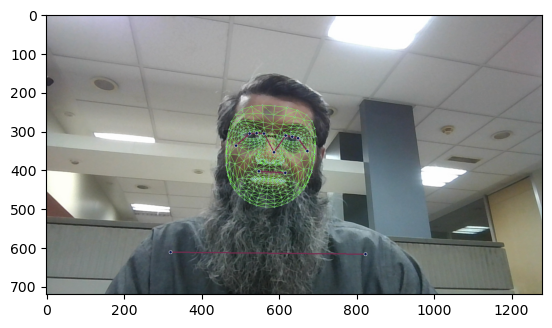

In [22]:
plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))

In [11]:
# len(results.right_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [15]:
# pose = []
# for res in results.pose_landmarks.landmark:
#     test = np.array([res.x, res.y, res.z, res.visibility])
#     pose.append(test)

In [17]:
# test.shape

(4,)

In [117]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [26]:
result_test = extract_keypoints(results)
result_test

array([ 0.4599885 ,  0.49309859, -0.97429734, ...,  0.        ,
        0.        ,  0.        ])

In [28]:
np.save("0", result_test)

In [30]:
np.load("0.npy")

array([ 0.4599885 ,  0.49309859, -0.97429734, ...,  0.        ,
        0.        ,  0.        ])

# Setup Folder for Collection

In [32]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
# start_folder = 30

In [32]:
print(DATA_PATH)

MP_Data


In [119]:
for action in actions: 
    # dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collect keypoint values for Training & Testing

In [33]:
cap = cv.VideoCapture(0)

# Set webcam width and height
cap.set(3,1280)

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    #NEW LOOP
    # Loop through action
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequences length
            for frame_num in range(sequence_length):
                
                # Read Frame
                ret, frame = cap.read()
                frame = cv.flip(frame, 1)
                
                # Make detection
                image, results = mediapipe_detection(frame, holistic)
                
                # Draw Landmarks
                draw_styled_landmarks(image, results)
                
                # New apply wait logic
                if frame_num == 0:
                    cv.putText(image, "Starting Collection", (120,200),
                               cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv.LINE_AA)
                    cv.putText(image, "Collecting frames for {} video number {}".format(action, sequence), (15,12),
                               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv.LINE_AA)
                    
                    # Show to Screen
                    cv.imshow("Opencv Feed", image)
                    cv.waitKey(300)
                    
                else:
                    cv.putText(image, "Collecting frames for {} video number {}".format(action, sequence), (15,12),
                               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv.LINE_AA)
                    cv.imshow("Opencv Feed", image)

                # New Keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                # Brake gracefully
                if cv.waitKey(10) & 0xFF == ord("q"):
                    break
    cap.release()
    cv.destroyAllWindows()

In [35]:
# cap.release()
# cv.destroyAllWindows() 

In [41]:
# for action in actions:
#     print("Action: {}".format(action))
#     for sequence in range(start_folder, start_folder+no_sequences):
#         print("Sequence No.: {}".format(sequence))
#         for frame_num in range(sequence_length):
#             print("Frame No.: {}".format(frame_num))

Action: hello


NameError: name 'start_folder' is not defined

# Preprocess Data and Create Labels and Features

In [121]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [123]:
label_map = {label:num for num, label in enumerate(actions)}

In [125]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [127]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [46]:
np.array(sequences).shape

(90, 30, 1662)

In [48]:
np.array(labels).shape

(90,)

In [129]:
X = np.array(sequences)

In [131]:
X.shape

(90, 30, 1662)

In [133]:
y = to_categorical(labels).astype(int)

In [135]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [60]:
y_test.shape

(5, 3)

# Build and Train LSTM Neural Network

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping 

In [68]:
log_dir = os.path.join("Logs")
tb_callbacks = TensorBoard(log_dir=log_dir)

In [70]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation="relu", input_shape=(30, 1662)))

model.add(LSTM(128, return_sequences=True, activation="relu"))

model.add(LSTM(64, return_sequences=False, activation="relu"))

model.add(Dense(64, activation="relu"))


model.add(Dense(32, activation="relu"))

model.add(Dense(actions.shape[0], activation="softmax"))

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 596675 

In [74]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [69]:
model.fit(X_train, y_train, epochs=175, callbacks=[tb_callbacks])

Epoch 1/175
3/3 [==============================] - 4s 92ms/step - loss: 1.1381 - categorical_accuracy: 0.3294
Epoch 2/175
3/3 [==============================] - 0s 85ms/step - loss: 1.2861 - categorical_accuracy: 0.3059
Epoch 3/175
3/3 [==============================] - 0s 85ms/step - loss: 1.1121 - categorical_accuracy: 0.4471
Epoch 4/175
3/3 [==============================] - 0s 83ms/step - loss: 1.1579 - categorical_accuracy: 0.2588
Epoch 5/175
3/3 [==============================] - 0s 85ms/step - loss: 1.1473 - categorical_accuracy: 0.3882
Epoch 6/175
3/3 [==============================] - 0s 81ms/step - loss: 0.9852 - categorical_accuracy: 0.4588
Epoch 7/175
3/3 [==============================] - 0s 88ms/step - loss: 1.0268 - categorical_accuracy: 0.5059
Epoch 8/175
3/3 [==============================] - 0s 91ms/step - loss: 1.8290 - categorical_accuracy: 0.5529
Epoch 9/175
3/3 [==============================] - 0s 108ms/step - loss: 1.0795 - categorical_accuracy: 0.4353
Epoch 10/

# Make Predictions

In [139]:
res = model.predict(X_test)

1/1 [==============================] - 0s 233ms/step


In [141]:
actions[np.argmax(res[4])]

'hello'

# Save Weights

In [75]:
model.save("action.h5")

C:\Users\atif\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [143]:
model.load_weights("action.h5")

# Evaluation Using Confusion Matrix and Accuracy

In [145]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [147]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 44ms/step


In [149]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [151]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[2, 0],
        [0, 3]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [155]:
accuracy_score(ytrue, yhat)

1.0

# Test in Real Time

In [93]:
from scipy import stats

In [99]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv.putText(output_frame, actions[num], (0, 85+num*40), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv.LINE_AA)
        
    return output_frame

In [101]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [161]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv.VideoCapture(0)

# Set webcam width and height
cap.set(3, 1280)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        frame = cv.flip(frame, 1)

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            # print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv.putText(image, ' '.join(sentence), (3,30), 
                       cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv.LINE_AA)
        
        # Show to screen        
        cv.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv.destroyAllWindows()

1/1 [==============================] - 0s 28ms/step


In [412]:
# cap.release()
# cv.destroyAllWindows()